# Purpose:
- Calculate clustering index change between sessions using subsampled trials
    - To match "during touch" whisker feature distribution
    - Either continuous or discontinuous sessions
    - Either using different set of neurons or matched cells
    - Use results from 240411_trial_subsampling_dev.ipynb (and scripts/trial_subsampling_par.py)

In [1]:
import numpy as np
import pandas as pd
from importlib import reload
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import matplotlib
matplotlib.style.use('default')
import xarray as xr
from utils import lda_angle_discrim as lad
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from scipy.spatial.distance import pdist, squareform
from scipy.optimize import linear_sum_assignment
import utils.lda_angle_discrim as lda_angle
import utils.logistic_regression_angle as logireg_angle
import utils.clustering_index as ci
import pickle


# base_dir = Path(r'E:\TPM\JK\h5')
base_dir = Path(r'C:\JK')

results_dir = base_dir / 'results'
# wf_dir = results_dir / 'touch_whisker_features'
# b_dir = Path(r'E:\TPM\JK\SoloData')

expert_mice_df = pd.read_csv(base_dir / 'expert_mice.csv', index_col=0)
use_mice_df = expert_mice_df.loc[expert_mice_df['depth_matched'].astype(bool) & 
                                 ~expert_mice_df['processing_error'].astype(bool) &
                                 ((expert_mice_df.session_type == 'training') |
                                  (expert_mice_df.session_type.str.contains('test')))]
use_volume_df = use_mice_df.query('plane in [1, 5]')
use_volume_df.loc[:, 'volume'] = use_volume_df['plane'].apply(lambda x: 1 if x==1 else 2)
training_volume_df = use_volume_df.query('session_type == "training"')
remove_ind = training_volume_df.query('mouse==27 and session=="15"')
training_volume_df = training_volume_df.drop(remove_ind.index)
remove_ind = training_volume_df.query('mouse==36 and session=="9"')
training_volume_df = training_volume_df.drop(remove_ind.index)

mice = [25,27,30,36,39,52]
test_sessions = [[4,19], [3,8], [3,21], [1,17], [1,23], [3,21]]
naive_sessions = [10, 4, 11, 6, 6, 11]

c:\Users\shires\Anaconda3\envs\suite2p\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


# Try in one pair of sessions

In [28]:
mouse = 25
volume = 2
subsample_dir = results_dir / 'trial_subsampling'
subsample_fn = subsample_dir / f'JK{mouse:03}_volume{volume}_matching_trialNum_dict.pkl'
with open(subsample_fn, 'rb') as f:
    subsample_dict = pickle.load(f)
comp_sessions = [6, 7]



<module 'utils.clustering_index' from 'c:\\Users\\shires\\Dropbox\\Works\\Projects\\2020 Neural stretching in S1\\Analysis\\codes\\data_analysis\\utils\\clustering_index.py'>

In [2]:
def get_pair_ci(subsample_dict, comp_sessions, mouse, volume, results_dir,
                num_dims=7, num_trials_choose=15, balance_trials=False):
    temp_dict = subsample_dict[f'{comp_sessions[0]}_{comp_sessions[1]}']
    if temp_dict is None:
        tn_sessions = None
    else:
        tn_sessions = [temp_dict[f'{comp_sessions[i]}'] for i in range(2)]

    pop_res_dir = results_dir / 'pop_responses' / 'touch_before_answer'
    varexp_threshold = 0.05
    post_touch_frames = 1
    subsampled_cis = []
    all_trial_cis = []
    for si, session in enumerate(comp_sessions):
        touch_response_fn = f'JK{mouse:03}_volume{volume}_S{session:02}_ve_{varexp_threshold}_ptf_{post_touch_frames}.npy'
        touch_response_results = np.load(pop_res_dir / touch_response_fn, allow_pickle=True).item()
        response_xr = touch_response_results['per_touch_response_xr_fit']

        response_df = touch_response_results['per_touch_response_df']
        if tn_sessions is None:
            subsampled_cis.append(None)
        else:
            trialNums = tn_sessions[si]
            
            temp_xr = response_xr.sel(trialNum=trialNums)
            temp_df = response_df.query('trialNum in @trialNums')
            assert len(trialNums)%2 == 0
            
            subsampled_cis.append(ci.calculate_clustering_index(
                                temp_xr, temp_df, num_dims=num_dims,
                                num_trials_choose=num_trials_choose,
                                balance_trials=balance_trials)[0])
        if balance_trials:
            all_trial_cis.append(ci.calculate_clustering_index(
                                response_xr, response_df, num_dims=num_dims,
                                num_trials_choose=num_trials_choose,
                                balance_trials=True)[0])
        else:
            if tn_sessions is None:
                num_trials_to_choose_for_all_trials = num_trials_choose
            else:
                num_trials_to_choose_for_all_trials = int(len(trialNums) / 2) - 1
            all_trial_cis.append(ci.calculate_clustering_index(
                                response_xr, response_df, num_dims=num_dims,
                                num_trials_choose=num_trials_to_choose_for_all_trials,
                                balance_trials=True)[0])
    return subsampled_cis, all_trial_cis

In [30]:
reload(ci)

<module 'utils.clustering_index' from 'c:\\Users\\shires\\Dropbox\\Works\\Projects\\2020 Neural stretching in S1\\Analysis\\codes\\data_analysis\\utils\\clustering_index.py'>

Text(0.5, 1.0, 'JK025 volume 2 balaced=False')

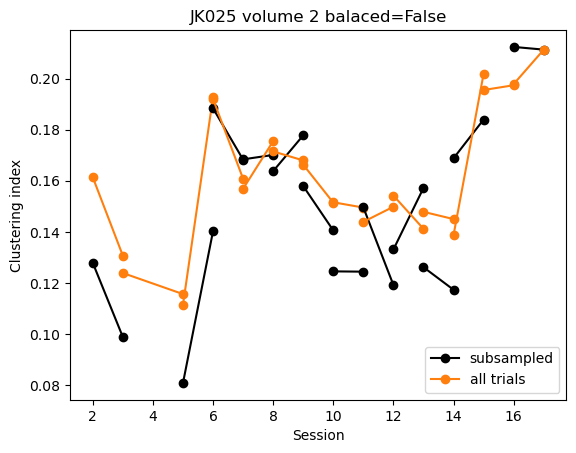

In [31]:
sessions = np.unique([int(k.split('_')[0]) for k in subsample_dict.keys()])
neighboring_pairs = [(sessions[i], sessions[i+1]) for i in range(len(sessions)-1)]
balance_trials = False # if False, use all the trials (no repeat),
# all trials ci will be calculated using the same number of trials (with balance_trials=True)
# if True, use specific number of trials (limited by min_num_trials of subsampling,
# repeat=100)
subsampled_ci_all = []
all_trial_ci_all = []
for pair in neighboring_pairs:
    subsampled_cis, all_trial_cis = get_pair_ci(subsample_dict, pair, mouse, volume, results_dir,
                                                balance_trials=balance_trials)
    subsampled_ci_all.append(subsampled_cis)
    all_trial_ci_all.append(all_trial_cis)

fig, ax = plt.subplots()
subsample_labeled = False
for pi, pair in enumerate(neighboring_pairs):
    if subsampled_ci_all[pi] is not None:
        if not subsample_labeled:
            ax.plot([pair[0], pair[1]], subsampled_ci_all[pi], 'ko-',
                    label='subsampled')
            subsample_labeled = True
        else:
            ax.plot([pair[0], pair[1]], subsampled_ci_all[pi], 'ko-')
    if pi == 0:
        ax.plot([pair[0], pair[1]], all_trial_ci_all[pi], 'o-', 
                color='C1', label='all trials')
    else:
        ax.plot([pair[0], pair[1]], all_trial_ci_all[pi], 'o-', 
                color='C1')

ax.legend(loc='lower right')
ax.set_xlabel('Session')
ax.set_ylabel('Clustering index')
# ax.set_ylim([0, 0.3])
ax.set_title(f'JK{mouse:03} volume {volume} balaced={balance_trials}')

Text(0.5, 1.0, 'JK025 volume 2 balaced=True')

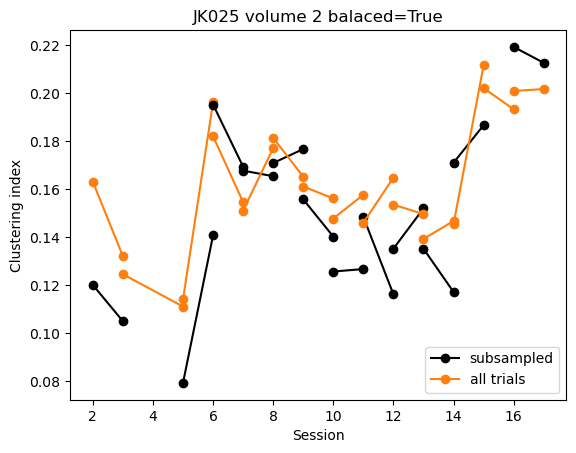

In [32]:
sessions = np.unique([int(k.split('_')[0]) for k in subsample_dict.keys()])
neighboring_pairs = [(sessions[i], sessions[i+1]) for i in range(len(sessions)-1)]
balance_trials = True # if False, use all the trials (no repeat),
# all trials ci will be calculated using the same number of trials (with balance_trials=True)
# if True, use specific number of trials (limited by min_num_trials of subsampling,
# repeat=100)
subsampled_ci_all = []
all_trial_ci_all = []
for pair in neighboring_pairs:
    subsampled_cis, all_trial_cis = get_pair_ci(subsample_dict, pair, mouse, volume, results_dir,
                                                balance_trials=balance_trials)
    subsampled_ci_all.append(subsampled_cis)
    all_trial_ci_all.append(all_trial_cis)

fig, ax = plt.subplots()
subsample_labeled = False
for pi, pair in enumerate(neighboring_pairs):
    if subsampled_ci_all[pi] is not None:
        if not subsample_labeled:
            ax.plot([pair[0], pair[1]], subsampled_ci_all[pi], 'ko-',
                    label='subsampled')
            subsample_labeled = True
        else:
            ax.plot([pair[0], pair[1]], subsampled_ci_all[pi], 'ko-')
    if pi == 0:
        ax.plot([pair[0], pair[1]], all_trial_ci_all[pi], 'o-', 
                color='C1', label='all trials')
    else:
        ax.plot([pair[0], pair[1]], all_trial_ci_all[pi], 'o-', 
                color='C1')

ax.legend(loc='lower right')
ax.set_xlabel('Session')
ax.set_ylabel('Clustering index')
# ax.set_ylim([0, 0.3])
ax.set_title(f'JK{mouse:03} volume {volume} balaced={balance_trials}')

# Try other volumes
- balanced=True (using only 15 trials)

In [33]:
def draw_neighboring_cis(mouse, volume, results_dir,
                        balance_trials = True # if False, use all the trials (no repeat),
                        # all trials ci will be calculated using the same number of trials (with balance_trials=True)
                        # if True, use specific number of trials (limited by min_num_trials of subsampling,
                        # repeat=100)
                        ):
    subsample_dir = results_dir / 'trial_subsampling'
    subsample_fn = subsample_dir / f'JK{mouse:03}_volume{volume}_matching_trialNum_dict.pkl'
    with open(subsample_fn, 'rb') as f:
        subsample_dict = pickle.load(f)    
    sessions = np.unique([int(k.split('_')[0]) for k in subsample_dict.keys()])
    neighboring_pairs = [(sessions[i], sessions[i+1]) for i in range(len(sessions)-1)]
    
    subsampled_ci_all = []
    all_trial_ci_all = []
    for pair in neighboring_pairs:
        subsampled_cis, all_trial_cis = get_pair_ci(subsample_dict, pair, mouse, volume, results_dir,
                                                    balance_trials=balance_trials)
        subsampled_ci_all.append(subsampled_cis)
        all_trial_ci_all.append(all_trial_cis)

    fig, ax = plt.subplots()
    subsample_labeled = False
    for pi, pair in enumerate(neighboring_pairs):
        if subsampled_ci_all[pi] is not None:
            if not subsample_labeled:
                ax.plot([pair[0], pair[1]], subsampled_ci_all[pi], 'ko-',
                        label='subsampled')
                subsample_labeled = True
            else:
                ax.plot([pair[0], pair[1]], subsampled_ci_all[pi], 'ko-')
        if pi == 0:
            ax.plot([pair[0], pair[1]], all_trial_ci_all[pi], 'o-', 
                    color='C1', label='all trials')
        else:
            ax.plot([pair[0], pair[1]], all_trial_ci_all[pi], 'o-', 
                    color='C1')

    ax.legend(loc='lower right')
    ax.set_xlabel('Session')
    ax.set_ylabel('Clustering index')
    # ax.set_ylim([0, 0.3])
    ax.set_title(f'JK{mouse:03} volume {volume} balaced={balance_trials}')
    return fig, ax

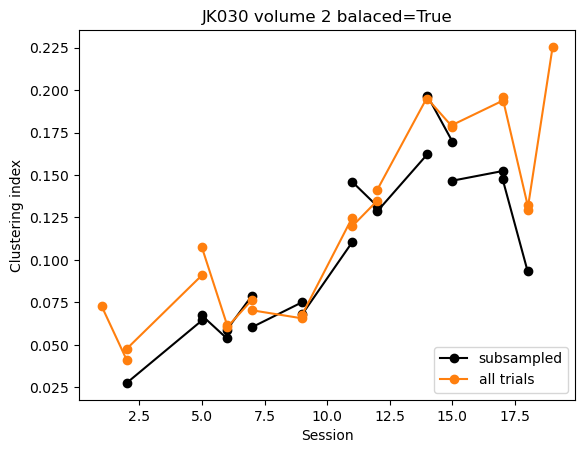

In [39]:
mouse = 30
volume = 2
fig, ax = draw_neighboring_cis(mouse, volume, results_dir, balance_trials=True)

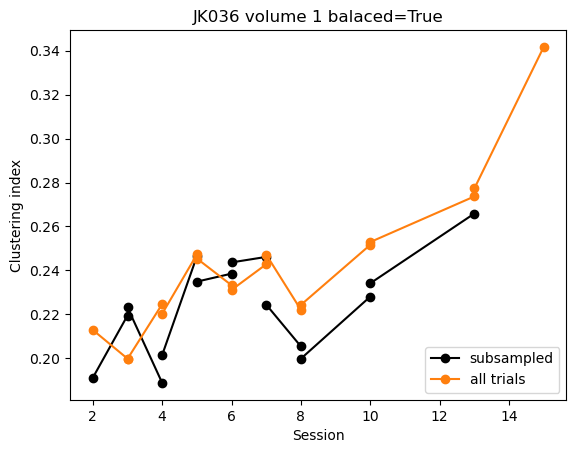

In [35]:
mouse = 36
volume = 1
fig, ax = draw_neighboring_cis(mouse, volume, results_dir, balance_trials=True)

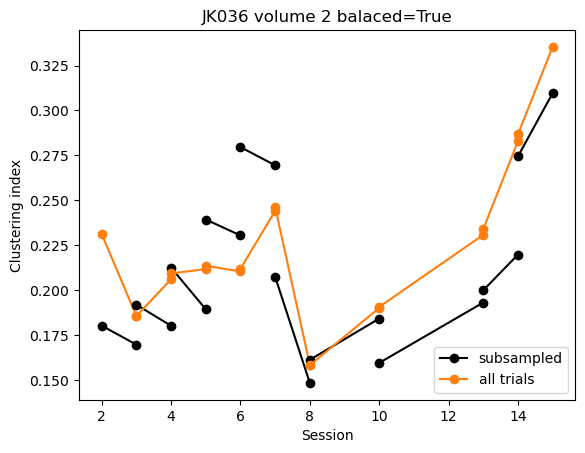

In [36]:
mouse = 36
volume = 2
fig, ax = draw_neighboring_cis(mouse, volume, results_dir, balance_trials=True)

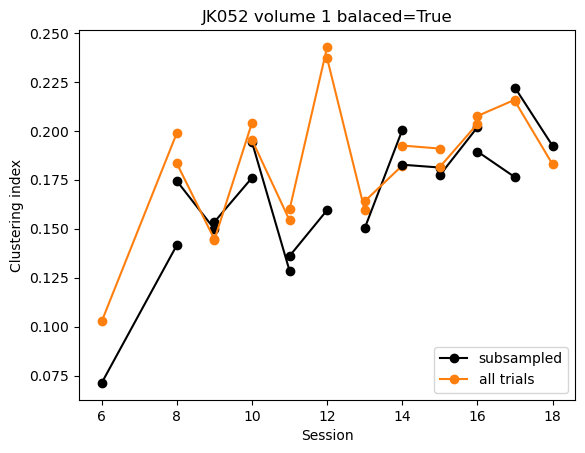

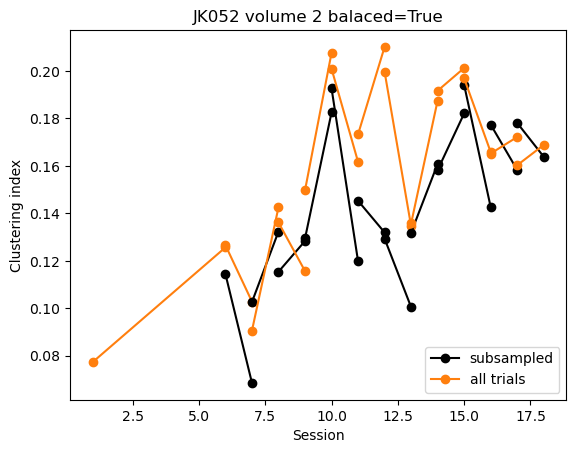

In [37]:
mouse = 52
volume = 1
fig, ax = draw_neighboring_cis(mouse, volume, results_dir, balance_trials=True)
volume = 2
fig, ax = draw_neighboring_cis(mouse, volume, results_dir, balance_trials=True)

# Effect of number of trials in clustering index
- vary the number of trials and see how clustering index changes

In [2]:
mouse = 25
volume = 2
sessions = np.sort([int(s) for s in training_volume_df.query('mouse == @mouse and volume == @volume').session.values])


In [9]:
np.arange(10, 60, 10)

array([10, 20, 30, 40, 50])

In [15]:
response_xr.isel(cell_id=1).mean()


<xarray.DataArray ()>
array(0.5925413, dtype=float32)
Coordinates:
    cell_id  <U7 'p5c0003'

In [23]:
reload(ci)
num_trials = np.arange(10, 60, 10)
si = 0
session = sessions[si]
pop_res_dir = results_dir / 'pop_responses' / 'touch_before_answer'
varexp_threshold = 0.05
post_touch_frames = 1
touch_response_fn = f'JK{mouse:03}_volume{volume}_S{session:02}_ve_{varexp_threshold}_ptf_{post_touch_frames}.npy'
touch_response_results = np.load(pop_res_dir / touch_response_fn, allow_pickle=True).item()
response_xr = touch_response_results['per_touch_response_xr_fit']
response_df = touch_response_results['per_touch_response_df']
max_num_trials = max(response_df.groupby('pole_angle').size().values)

num_dims = 7
ci_vals = []
for num_trial in num_trials:
    if num_trial < max_num_trials:
        ci_val = ci.calculate_clustering_index(response_xr, response_df, num_dims=num_dims,
                                            num_trials_choose=num_trial, balance_trials=True)
        ci_vals.append(ci_val)

In [24]:
ci_vals

[[0.006501774291518485],
 [0.0019050011348534846],
 [-0.00028200637175813557],
 [0.00204921590843281],
 [0.0076201817733827296]]